\pagebreak
\tableofcontents
\pagebreak

In [429]:
'''Importing Packages'''
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import datetime
from loess import loess_1d
from statsmodels.graphics.tsaplots import plot_acf
from openpyxl import Workbook, load_workbook
from sklearn import linear_model
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from scipy.linalg import toeplitz
%matplotlib inline

# Generate the time-series plot for "gnp"series that is to be indexed by "date" series. Visually inspect the plot and comment on whether there is a linear trend.

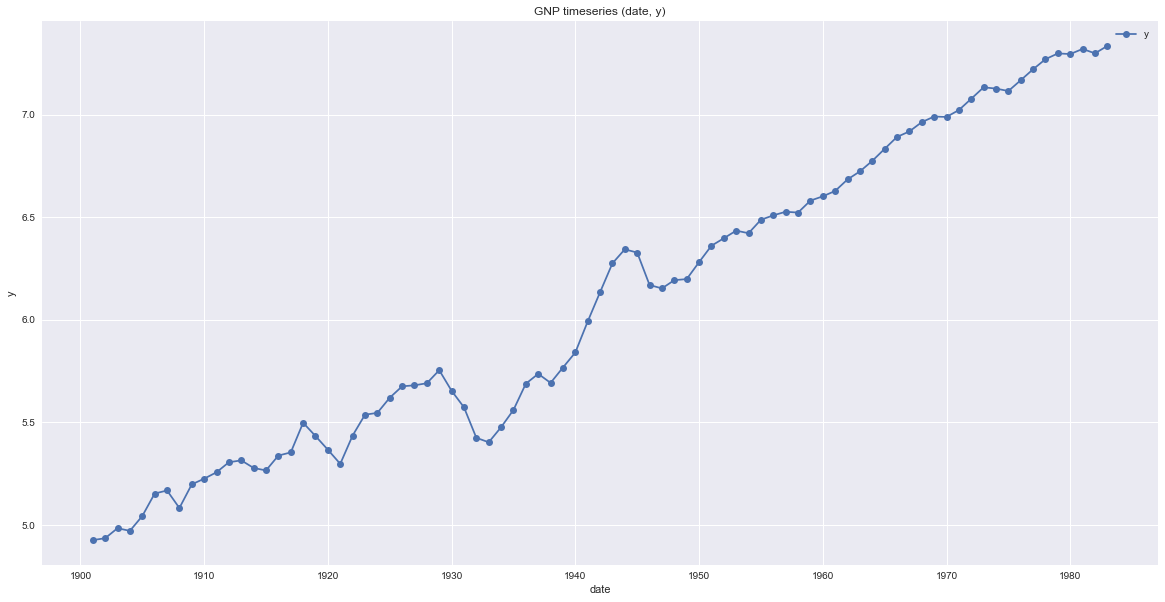

In [430]:
'''Reading in the data'''

data = pd.read_excel('GNP.xlsx', index_col='date')

'''Plotting'''
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(data['y'], marker = 'o', label = 'y')
    ax.set_xlabel('date')
    ax.set_ylabel('y')
    plt.title('GNP timeseries (date, y)')
    plt.legend()
    plt.show()

## Comments

There seems to be positive linear trend.

# Generate ACF and Variogram plots for "gnp"series and comment on whether it is stationary, why?

## ACF

<Figure size 1440x720 with 0 Axes>

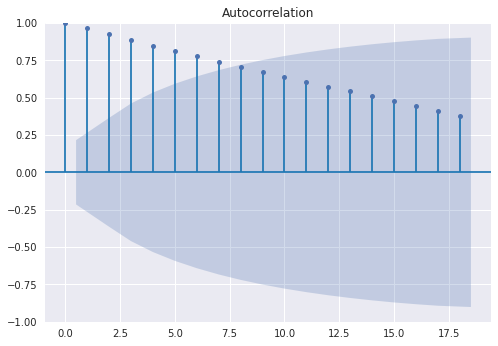

In [431]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    fig = plot_acf(data['y'], lags=18)

## Variogram

In [432]:
r1 = ts.acf(data['y'], nlags=int(len(data)/4))[1]
base_var  = np.var(data['y'])

variogram = pd.DataFrame(index = [i for i in range(1,int(len(data)/4))])
variogram['lagged'] = [np.var(np.array(data['y'].iloc[i:]) - np.array(data['y'].iloc[:-i]))/np.var(np.diff(data['y'])) for i in range(1,int(len(data)/4))]
variogram ['asymp'] = [1/(1-r1) for i in range(len(variogram))]

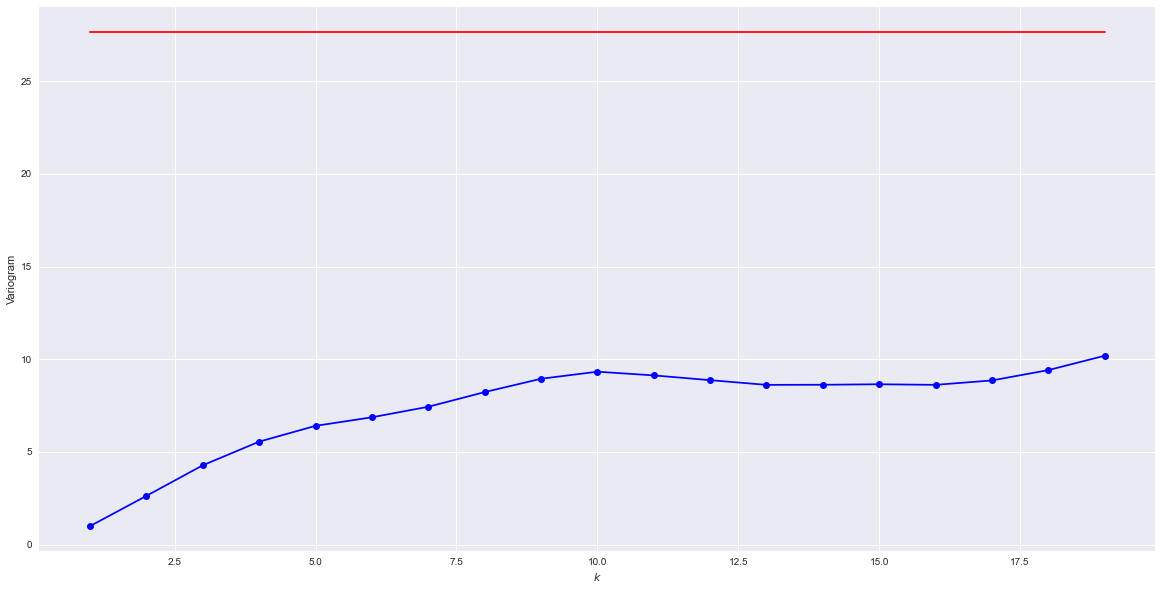

In [433]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(variogram['lagged'], c = 'Blue', marker = 'o')
    plt.plot(variogram['asymp'], c = 'Red')
    ax.set_xlabel('$k$')
    ax.set_ylabel('Variogram')
    plt.show()

## Comments

The above plots show that the current data is not stationary because the ACF plot shows that the auto-correlation is well above the signifigance levels. As for the Variogram with $\frac{1}{1-r_1}$ as our asymptote and lag $k = \frac{T}{4}$ does not pass the asymptote at all. 

\pagebreak

# Assuming linear trend in the series, regress "gnp" on "t" with simple linear regression (SLR) model and report the following.

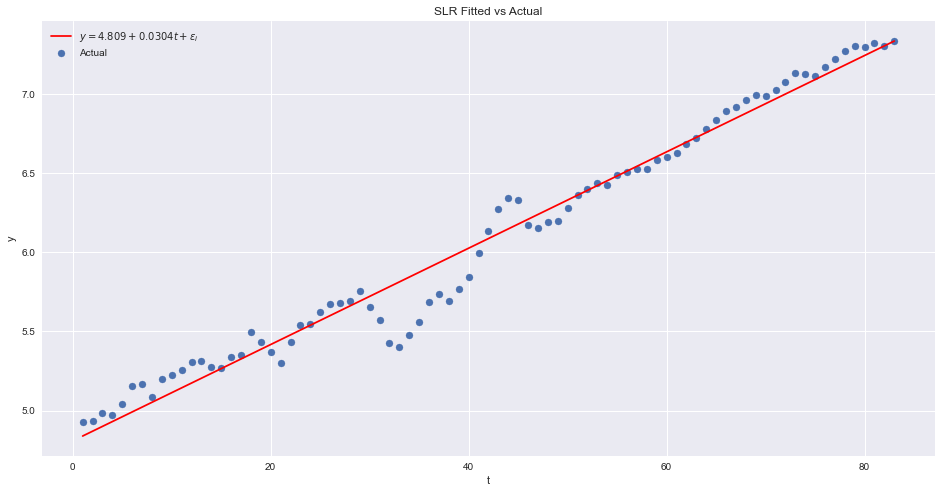

In [434]:
'''Setting up data for regression'''
data_on_t = data.reset_index()
data_on_t = data_on_t.drop(['date'], axis=1)
data_on_t['t'] = [float(i) for i in data_on_t['t']]

t = pd.DataFrame(data_on_t['t'])
y = pd.DataFrame(data_on_t['y'])

'''Performing the regression'''
x = sm.add_constant(t)
OLS_fit = sm.OLS(y, x)
est = OLS_fit.fit()
summary  = est.summary() #Summary dataframe

'''Getting eveyrthing into one df'''
predict = pd.DataFrame(index = t['t'], columns=[ 'actual', 'fitted values' , 'raw res'])
predict['fitted values'] = est.fittedvalues.values
predict['actual'] = y.values
predict['raw res'] = predict['actual'] - predict['fitted values']

with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(16,8))
    ax = plt.axes()
    plt.plot(predict['fitted values'], label = '$y = 4.809 + 0.0304t + \epsilon_i$', c='red')
    plt.scatter(predict.index.tolist(),predict['actual'], label = 'Actual')
    ax.set_xlabel('t')
    ax.set_ylabel('y')
    plt.title('SLR Fitted vs Actual')
    plt.legend()
    plt.show()

In [435]:
md(summary.as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &        y         & \textbf{  R-squared:         } &     0.973   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.972   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     2892.   \\
\textbf{Date:}             & Mon, 12 Sep 2022 & \textbf{  Prob (F-statistic):} &  3.80e-65   \\
\textbf{Time:}             &     20:08:10     & \textbf{  Log-Likelihood:    } &    56.863   \\
\textbf{No. Observations:} &          83      & \textbf{  AIC:               } &    -109.7   \\
\textbf{Df Residuals:}     &          81      & \textbf{  BIC:               } &    -104.9   \\
\textbf{Df Model:}         &           1      & \textbf{                     } &             \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
               & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const} &       4.8090  &        0.027     &   175.834  &         0.000        &        4.755    &        4.863     \\
\textbf{t}     &       0.0304  &        0.001     &    53.780  &         0.000        &        0.029    &        0.032     \\
\bottomrule
\end{tabular}
\begin{tabular}{lclc}
\textbf{Omnibus:}       & 28.315 & \textbf{  Durbin-Watson:     } &    0.241  \\
\textbf{Prob(Omnibus):} &  0.000 & \textbf{  Jarque-Bera (JB):  } &   43.763  \\
\textbf{Skew:}          & -1.454 & \textbf{  Prob(JB):          } & 3.14e-10  \\
\textbf{Kurtosis:}      &  5.050 & \textbf{  Cond. No.          } &     97.6  \\
\bottomrule
\end{tabular}
%\caption{OLS Regression Results}
\end{center}

Notes: \newline
 [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

## The fitted SLR model.

As we can see from the summary the fitted regression model $y = \beta_0 + \beta_i x_i$ is 

$$
y = 4.809 + 0.0304t + \epsilon_i
$$

## The significance of regression effect.

From the summary above we can see that the fitted model is significant based on the probabilities of the F-stat and p-values of the coefficients and thus for all $H_0$ can be rejected. This shows signifigance in the regression.

## Model diagnostics.

Refferring back to the summary table of the regression results. We can see that the test done for the model diagnostics include DW and JB. The DW score of $0.241$ shows auto-correlation of the residuals and there is signifigance with the JB test showing normality.

# Generate series and ACF plot for the raw residuals from the SLR fit. Comment on its plausible stationarity.

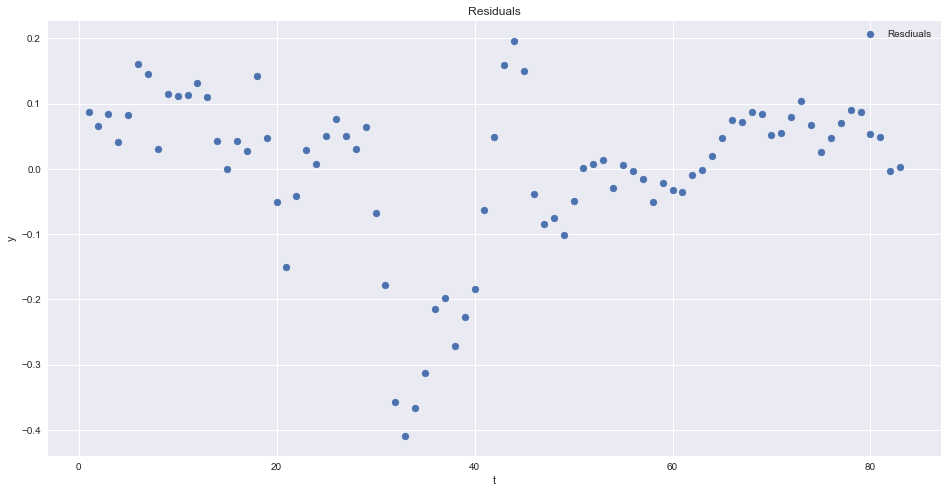

In [436]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(16,8))
    ax = plt.axes()
    plt.scatter(predict.index.tolist(),est.resid, label = 'Resdiuals')
    ax.set_xlabel('t')
    ax.set_ylabel('y')
    plt.title('Residuals')
    plt.legend()
    plt.show()

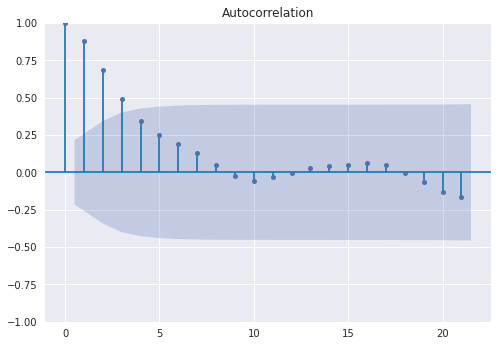

In [437]:
with plt.style.context('seaborn'):
    fig = plot_acf(est.resid, lags=21)

## Comments
Based on the the ACF, we can see that there seems to be exponential deacy and thus is indicative of a stationary process.

# Referring to "TSA04.R" for the use of gls function (nlme package is required), perform the second order Cochrane-Orcutt procedure and report the fitted autoregression model (with the estimates of $\phi_1$ and $\phi_2$)

We must first start presenting the formulation of the second order Autoregression model:

Let us first present the following for $y_t$:

$$
\begin{split}
y_t &= \beta_0+\beta_1x_t+\epsilon_t \\
\\
y_{t-1} &= \beta_0+\beta_1x_{t-1}+\epsilon_{t-1} \\
\\
y_{t-2} &= \beta_0+\beta_1x_{t-2}+\epsilon_{t-2} \\
\\
\end{split}
$$


Introducing our parameter $\phi_i$ we arrive at:

$$
\begin{split}
\\
y_t &= \beta_0+\beta_1x_t+\epsilon_t \\
\\
\phi_1 y_{t-1} &= \phi_1\beta_0 + \phi_1\beta_1x_{t-1} + \phi_1\epsilon_{t-1} \\
\\
\phi_2 y_{t-2} &= \phi_2\beta_0 + \phi_2\beta_1x_{t-2} + \phi_2\epsilon_{t-2} \\
\\
\end{split}
$$

Since we are formulating the second order Autoregressive model we will show the following:
$$
\\
y_t - \phi_1 y_{t-1} - \phi_2 y_{t-2} = \beta_0(1-\phi_1-\phi_2) + \beta_1(x_t-\phi_1x_{t-1}-\phi_2x_{t-2}) + (\epsilon_t-\phi_1\epsilon_{t-1}-\phi_2\epsilon_{t-2})
\\
$$

Where:

$$
\begin{split}
\\
y_t^{''} &= (1-\phi_1-\phi_2)y_t \\
\\
x_t^{''} &= (1-\phi_1-\phi_2)x_t \\
\\
\beta_0^{''} &= (1-\phi_1-\phi_2)\beta_0 \\
\\
\epsilon_t &= \phi_1\epsilon_{t-1}+\phi_2\epsilon_{t-2} +a_t \\
\\
\end{split}
$$

Thus:

$$
y_t^{''} = \beta_0^{''} + \beta_1x_t^{''} + a_t
$$

In [438]:
import rpy2.robjects as robjects
from rpy2.robjects import FloatVector
from rpy2.robjects.packages import importr
from rpy2.robjects import DataFrame

base = importr('base')
nlme = importr('nlme')
rsummary = robjects.r['summary']

y_r = FloatVector(y.values)
t_r = FloatVector(t.values)

fmla = robjects.Formula('y_r ~ t_r')

env = fmla.environment
env['y_r'] = y_r
env['t_r'] = t_r

fit = nlme.gls(fmla, correlation = nlme.corARMA(p=2), method="ML")
print(rsummary(fit))

Generalized least squares fit by maximum likelihood
  Model: y_r ~ t_r 
  Data: NULL 
        AIC       BIC   logLik
  -238.0689 -225.9747 124.0345

Correlation Structure: ARMA(2,0)
 Formula: ~1 
 Parameter estimate(s):
      Phi1       Phi2 
 1.2040997 -0.3748382 

Coefficients:
               Value  Std.Error  t-value p-value
(Intercept) 4.820705 0.06531402 73.80812       0
t_r         0.030221 0.00132936 22.73360       0

 Correlation: 
    (Intr)
t_r -0.855

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-3.4544505 -0.3167343  0.2016143  0.6100012  1.6131489 

Residual standard error: 0.1200595 
Degrees of freedom: 83 total; 81 residual



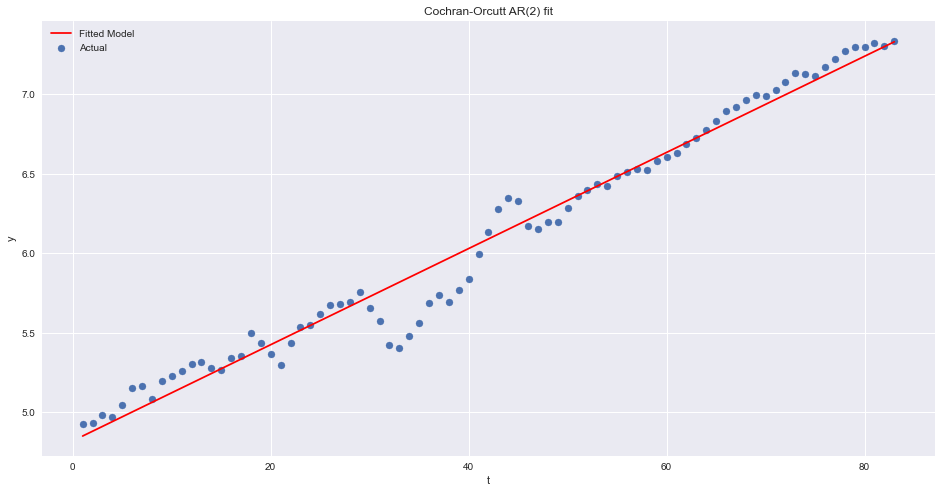

In [439]:
co_df = pd.DataFrame(index=t['t'], columns=['fitted'])
co_df['fitted'] = [fit[12][i] for i in range(len(fit[13]))]

with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(16,8))
    ax = plt.axes()
    plt.plot(co_df, label = 'Fitted Model', c = 'Red')
    plt.scatter(t,y, label = 'Actual')
    ax.set_xlabel('t')
    ax.set_ylabel('y')
    plt.title('Cochran-Orcutt AR(2) fit')
    plt.legend()
    plt.show()

# Generate ACF plot for the raw residuals from the SLR fit. Comment on the significance of its autocorrelation across the lags.

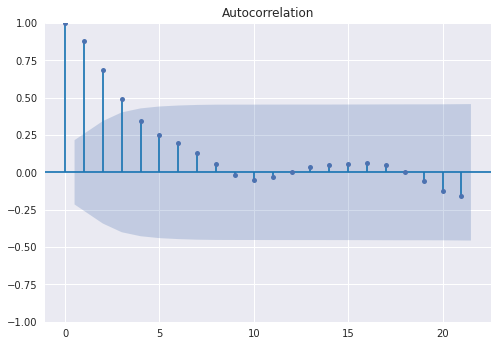

In [440]:
reside = [fit[13][i] for i in range(len(fit[13]))]
with plt.style.context('seaborn'):
    fig = plot_acf(reside, lags=21)

## Comments

The ACF above almost completely matches the prior residuals and thus we can conclude stationarity.
